Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/UXxKz/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 1.6
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/support/hmc_core.jl:235
┌ Warning: 5.797573426792418 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 44.646951022766245 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 11.65010975825147 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 6.5028684577821725 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt

Look at the generated draws (in chn)

In [8]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean         SD       Naive SE       MCSE        ESS   
  lf_num  0.0000000000 0.00000000 0.0000000000 0.000000000        NaN
 elapsed  0.0028174724 0.08788873 0.0019652519 0.002512033 1224.09656
 epsilon  0.9371658031 0.34954683 0.0078161048 0.027139002  165.89106
   theta  0.6442841309 0.13854530 0.0030979670 0.005166875  718.99789
      lp -3.3124825551 0.81072487 0.0181283593 0.031130084  678.24468
eval_num  7.1070000000 3.42964025 0.0766890873 0.082120258 1744.20095
  lf_eps  0.9371658031 0.34954683 0.0078161048 0.027139002  165.89106

Quantiles:
              2.5%          25.0%         50.0%         75.0%          97.5%    
  lf_num  0.0000000000  0.00000000000  0.000000000  0.00000000000  0.00000000000
 elapsed  0.0001263458  0.00013512325  0.000323556  0.00035258225  0.00073470635
 epsilon  0.5410190728  0.89833047246  0.898330472  0.89833047246  1.687393

Look at the mean and sd

In [9]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.6453979553416439, 0.13645288634282313)



Fix the inclusion of adaptation samples

In [10]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.0306924 … 4.0 0.89833; 0.0 0.00029545 … 4.0 0.89833; … ; 0.0 0.000133586 … 4.0 0.89833; 0.0 0.000334986 … 10.0 0.89833]

Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean                 SD                     Naive SE                    MCSE               ESS   
  lf_num  0.00000000000 0.0000000000000000000000 0.00000000000000000000000 0.000000000000000000000000       NaN
 elapsed  0.00030541553 0.0008364511010690936239 0.00001971534152323034373 0.000020396112351449130609 1681.8464
 epsilon  0.89833047246 0.0000000000000012215847 0.00000000000000002879303 0.000000000000000026926864 1800.0000
   theta  0.64539795534 0.1364528863428231264532 0.00321622537484958287077 0.005685267202029012367781  576.0547
      lp -3.29262993036 0.7276156183975894808924 0.01715006459553929107908 0.017625070374243104881495 1704.2853
eval_num  7.04333333333 3.0005206144524843026034 0.07072294911897926417144 0.076972960195819353779179 1519.5565
  lf_eps  0.89833047246 0.0000000000000012215847 0.00000000000000002879303 0.000000000000000026926864 1800

Compute at hpd region

In [12]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

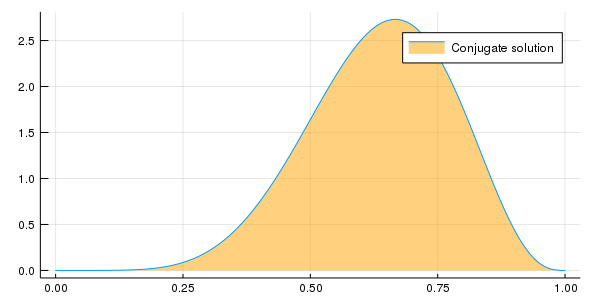

In [13]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

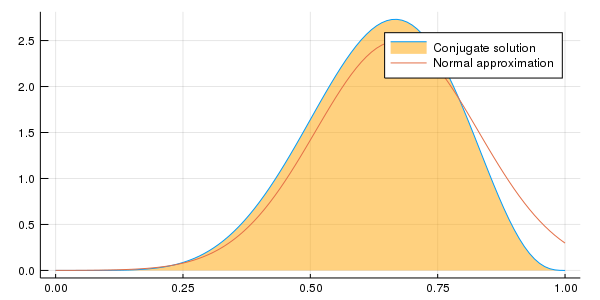

In [14]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

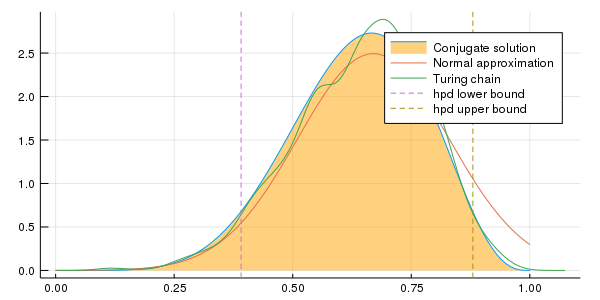

In [15]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [16]:
println("hpd bounds = $bnds\n")

hpd bounds =       94% Lower 94% Upper
theta 0.3911217 0.8799579





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*